In [1]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import defaultdict, Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import warnings
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import itertools

# Suppress specific warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="wordcloud")

csfont = {'fontname':'Times New Roman'}

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/norika_machome/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/norika_machome/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/norika_machome/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Cleaning and Tokenization / Lemmatization


In [18]:
# Load data
df = pd.read_csv("summaries.csv")

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the replacements for specific phrases
phrase_replacements = {
    'internet of things': 'iot',
    'artificial intelligence': 'ai',
    'sustainable development goals': 'sdgs',
    'greenhouse gases': 'ghg',
    'information and communication technology': 'ict',
    'virtual reality': 'vr',
    'intellectual property': 'ip',
    'intellectual properties': 'ip',
    'augmented reality': 'ar',
    'cyber security': 'cybersecurity',
    'small modular reactors': 'smrs',
    'r&d': 'research_development'
}

def replace_phrases(text):
    text = text.lower()  # Ensure text is lowercase
    for phrase, abbreviation in phrase_replacements.items():
        text = text.replace(phrase, abbreviation)
    return text

def clean_and_tokenize(text):
    text = replace_phrases(text)
    text = text.replace('\n', ' ')

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove punctuation and stopwords, and lemmatize
    stop_words = set(stopwords.words('english'))
    tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.isalpha() and word.lower() not in stop_words]

    # Join the tokens back into a string for Cleaned Text
    cleaned_text = ' '.join(tokens)
    return cleaned_text, tokens

# Apply the cleaning and tokenization function to the 'Text' column
df['Cleaned Text'], df['Tokenized Text'] = zip(*df['Text'].apply(clean_and_tokenize))

# Train a bigram model
phrases = Phrases(df['Tokenized Text'], min_count=5, threshold=10)
bigram = Phraser(phrases)
df['Bigram Text'] = df['Tokenized Text'].apply(lambda x: bigram[x])

df.head()

unique_word_count_by_year = {}
total_word_count = {}
word_freq_by_year = {}

for year, group in df.groupby('Year'):
    all_words = [word for sublist in group['Bigram Text'] for word in sublist]
    unique_words = set(all_words)
    unique_word_count_by_year[year] = len(unique_words)
    total_word_count[year] = len(all_words)

unique_word_count_df = pd.DataFrame.from_dict(unique_word_count_by_year, orient='index', columns=['Unique Word Count'])

for year, group in df.groupby('Year'):
    all_words = [word for sublist in group['Bigram Text'] for word in sublist]
    word_counts = Counter(all_words)
    word_freq_by_year[year] = word_counts

# Convert word frequencies to a DataFrame
word_freq_df = pd.DataFrame(word_freq_by_year).fillna(0).astype(int)

# Normalize the word frequencies
normalized_word_freq_df = word_freq_df.copy()
for year in normalized_word_freq_df.columns:
    normalized_word_freq_df[year] = normalized_word_freq_df[year] / total_word_count[year]

# Optionally multiply by 100 to get percentage
normalized_word_freq_df = normalized_word_freq_df * 100

In [3]:
normalized_word_freq_df

,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
science_technology,0.640569,1.868782,1.299562,0.998890,0.580967,0.832061,0.586347,0.329455,0.319822,0.687460,0.509895,0.531487,0.508672,0.707363,0.777486,0.640356,0.703060,0.520833,0.436150,0.472346
society_forum,0.017794,0.322667,0.318260,0.273201,0.000000,0.000000,0.000000,0.000000,0.000000,0.407384,0.008642,0.024158,0.030643,0.045933,0.057238,0.059040,0.057899,0.059393,0.050325,0.048446
society,0.747331,0.833557,0.490651,0.256126,0.286392,0.335878,0.321095,0.252348,0.201627,0.203692,0.561749,0.429484,0.425936,0.909467,0.810875,0.971888,0.847808,0.552814,0.272594,0.351231
light_shadow,0.106762,0.053778,0.066304,0.034150,0.040913,0.030534,0.020941,0.007010,0.013905,0.006365,0.023046,0.010737,0.021450,0.013780,0.066778,0.031791,0.033085,0.013706,0.062906,0.044409
inaugural,0.053381,0.000000,0.000000,0.000000,0.008183,0.000000,0.000000,0.000000,0.000000,0.000000,0.005762,0.000000,0.000000,0.009187,0.004770,0.000000,0.000000,0.000000,0.004194,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
khafji,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004037
ltdsouth,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004037
nrct,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004037
envista,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004037


In [24]:
# Function to format y-axis ticks as 'K'
def thousands_formatter(x, pos):
    return f'{int(x / 1000)}K'

# Function to plot total word count over years
def plot_total_word_count(total_word_count, title):
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 7))
    plt.rcParams['font.family'] = 'Times New Roman'
    
    years = list(total_word_count.keys())
    counts = list(total_word_count.values())
    
    sns.lineplot(x=years, y=counts, marker='o', color='blue')
    
    plt.xlabel('Year', fontsize=16, **csfont)
    plt.ylabel('Total Word Count', fontsize=16, **csfont)
    plt.title(title, fontsize=20, fontweight='bold', **csfont)
    plt.xticks(ticks=[int(year) for year in years], fontsize=14, **csfont)  # Ensure years are displayed as integers
    plt.yticks(fontsize=14, **csfont)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))  # Apply the formatter to y-axis ticks
    plt.axvline(x=2013.5, color='gray', linestyle='--', linewidth=1)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('images/total_word_count.png')
    plt.show()

# Function to plot total unique word count over years
def plot_total_unique_word_count(unique_word_count_df, title):
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 7))
    plt.rcParams['font.family'] = 'Times New Roman'
    
    years = unique_word_count_df.index
    counts = unique_word_count_df['Unique Word Count']
    
    sns.lineplot(x=years, y=counts, marker='o', color='green')
    
    plt.xlabel('Year', fontsize=16, **csfont)
    plt.ylabel('Total Unique Word Count', fontsize=16, **csfont)
    plt.title(title, fontsize=20, fontweight='bold', **csfont)
    plt.xticks(ticks=[int(year) for year in years], fontsize=14, **csfont)  # Ensure years are displayed as integers
    plt.yticks(fontsize=14, **csfont)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))  # Apply the formatter to y-axis ticks
    plt.axvline(x=2013.5, color='gray', linestyle='--', linewidth=1)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('images/total_unique_word_count.png')
    plt.show()

def generate_word_clouds(df, years_to_plot):
    # Add custom stopwords if needed
    custom_stopwords = set(STOPWORDS)
    custom_stopwords.update(['also', 'science', 'technology', 'science_technology', 'said'])

    word_freq_by_year = {}
    def filter_words(word_freq):
        return {word: freq for word, freq in word_freq.items() if word not in custom_stopwords}
    for year in years_to_plot:
        if year in df.columns:
            word_freq_by_year[year] = {word.lower(): freq for word, freq in df[year].to_dict().items()}
            word_freq_by_year[year] = filter_words(word_freq_by_year[year])

    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    axes = axes.flatten()
    for ax, (year, word_freq) in zip(axes, word_freq_by_year.items()):
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            colormap='viridis',
            max_words=50,  # Adjusted to show fewer words
            relative_scaling=0.8,  # Increased scaling to highlight differences
            font_path='/System/Library/Fonts/Supplemental/Times New Roman.ttf',
            stopwords=custom_stopwords
        ).generate_from_frequencies(word_freq)
        
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f'{year}', fontsize=28, fontweight='bold', fontname='Times New Roman')

    if len(word_freq_by_year) < 6:
        for i in range(len(word_freq_by_year), 6):
            fig.delaxes(axes[i])
    plt.tight_layout()
    plt.savefig('images/world_cloud.png')
    plt.show()

def plot_word_trends(words, title, df, normalized=False):
    sns.set(style="whitegrid")

    # Determine the total counts directly inside the function if needed
    if normalized:
        total_word_count = df.sum()

    # Set the year range based on the dataframe columns
    years = df.columns

    plt.figure(figsize=(12, 7))
    plt.rcParams['font.family'] = 'Times New Roman'
    for word in words:
        if word in df.index:
            # Check if normalized data needs to be plotted
            data_to_plot = df.loc[word] / total_word_count if normalized else df.loc[word]
            sns.lineplot(data=data_to_plot, label=word, marker='o')
            if not normalized:
                plt.axvline(x=2013.5, color='gray', linestyle='--', linewidth=1)

    plt.ylabel('Normalized Frequency (%)' if normalized else 'Frequency', fontsize=16, **csfont)
    plt.title(title, fontsize=20, fontweight='bold', **csfont)
    # plt.legend(fontsize=18, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(labels))
    plt.legend(fontsize=18, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

    plt.xticks(ticks=[int(year) for year in years], fontsize=14, **csfont)  # Ensure years are displayed as integers
    plt.yticks(fontsize=14, **csfont)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'images/{title.replace(" ", "_").lower()}.png')
    plt.show()

def plot_cumulative_word_groups_trends(word_groups, labels, title, df, normalized=False):
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 8))

    if len(word_groups) != len(labels):
        raise ValueError("The number of labels must match the number of word groups.")

    # Set the year range based on the dataframe columns
    years = df.columns

    for words, label in zip(word_groups, labels):
        cumulative_freq = pd.DataFrame(index=years)
        for word in words:
            if word in df.index:
                cumulative_freq[word] = df.loc[word]
        cumulative_freq['Cumulative'] = cumulative_freq.sum(axis=1)

        if normalized:
            # Normalize the cumulative frequency by the total word count for each year
            total_words_per_year = df.sum(axis=0)
            normalized_cumulative_freq = cumulative_freq['Cumulative'] / total_words_per_year
            sns.lineplot(data=normalized_cumulative_freq, label=label, marker='o')
        else:
            sns.lineplot(data=cumulative_freq['Cumulative'], label=label, marker='o')

    if not normalized:
        plt.axvline(x=2013.5, color='gray', linestyle='--', linewidth=1)
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.ylabel('Normalized Cumulative Frequency (%)' if normalized else 'Cumulative Frequency', fontsize=16, **csfont)
    plt.title(title, fontsize=20, fontweight='bold', **csfont)
    plt.legend(fontsize=18, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(labels))
    plt.xticks(ticks=[int(year) for year in years], fontsize=14,  **csfont)
    plt.yticks(fontsize=14, **csfont)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'images/{title.replace(" ", "_").lower()}.png')
    plt.show()


In [26]:
# plot_total_word_count(total_word_count, 'Total Word Count in Reports Over 20 Years')
# plot_total_unique_word_count(unique_word_count_df, 'Total Unique Word Count in Reports Over 20 Years')
# generate_word_clouds(normalized_word_freq_df, [2004, 2009, 2014, 2019, 2023])

# # Normalized plots
# plot_word_trends(['ai', 'big_data', 'digital'], 'Trend in Emerging Topics related to Technology 1', normalized_word_freq_df, True)
# plot_word_trends(['cybersecurity','algorithm', 'quantum'], 'Trend in Emerging Topics related to Technology 2', normalized_word_freq_df, True)
# plot_word_trends(['sdgs', 'green',  'global_common'], 'Trend in Emerging Topics related to Sustainability', normalized_word_freq_df, True)
# plot_word_trends(['pandemic', 'vaccine'], 'Trend in Emerging Topics
#  related to Pandemic', normalized_word_freq_df, True)
# plot_word_trends(['climate_change', 'carbon', 'adaptation', 'fusion'], 'Trend in Emerging Topics related to Climate Change', normalized_word_freq_df, True)
# plot_word_trends(['dna', 'semiconductor', 'startup'], 'Trends in Emerging Topics related to Innovation', normalized_word_freq_df, True)
# plot_word_trends(['resilience', 'trust', 'inclusive', 'inequality'], 'Trends in Emerging Topics related to Society and Ethics', normalized_word_freq_df, True)
# plot_word_trends(['nanotechnology', 'internet', 'ict'], 'Trend in Disappearing Topics 1', normalized_word_freq_df, True)
# plot_word_trends(['infectious_disease', 'developing_country', 'stem_cell'], 'Trend in Disappearing Topics 2', normalized_word_freq_df, True)

# Absolute count plots
# plot_word_trends(['ai', 'big_data', 'digital'], 'Trend in Emerging Topics related to Technology 1  Absolute Count', word_freq_df, False)
# plot_word_trends(['cybersecurity', 'algorithm', 'quantum'], 'Trend in Emerging Topics related to Technology 2  Absolute Count', word_freq_df, False)
# plot_word_trends(['sdgs', 'green', 'global_common'], 'Trend in Emerging Topics related to Sustainability  Absolute Count', word_freq_df, False)
# plot_word_trends(['pandemic', 'vaccine'], 'Trend in Emerging Topics related to Pandemic  Absolute Count', word_freq_df, False)
# plot_word_trends(['climate_change', 'carbon', 'adaptation', 'fusion'], 'Trend in Emerging Topics related to Climate Change  Absolute Count', word_freq_df, False)
# plot_word_trends(['dna', 'semiconductor', 'startup'], 'Trends in Emerging Topics related to Innovation  Absolute Count', word_freq_df, False)
# plot_word_trends(['resilience', 'trust', 'inclusive', 'inequality'], 'Trends in Emerging Topics related to Society and Ethics  Absolute Count', word_freq_df, False)
# plot_word_trends(['nanotechnology', 'internet', 'ict'], 'Trend in Disappearing Topics 1  Absolute Count', word_freq_df, False)
# plot_word_trends(['infectious_disease', 'developing_country', 'stem_cell'], 'Trend in Disappearing Topics 2  Absolute Count', word_freq_df, False)

# plot_word_trends(['iot',  'smart_city'], 'Trend in Topics with Middle Spike  Absolute', word_freq_df, False)
# plot_word_trends(['iot',  'smart_city'], 'Trend in Topics with Middle Spike', normalized_word_freq_df, True)

# 'iot',  'smart_city', 'renewable_energy', 'gene_editing',  'smart_grid','telemedicine',


# plot_word_trends(['university', 'government', 'industry'] , 'Stakeholders', word_freq_df, False)
# plot_word_trends(['university', 'government', 'industry'] , 'Stakeholders', normalized_word_freq_df, True)

# # Example word groups and labels
# words = [
#     ['energy', 'coal', 'oil', 'natural_gas', 'nuclear_energy', 'fossil_fuel', 'renewable_energy'],
#     ['climate_change', 'emissions', 'greenhouse_gases', 'carbon', 'carbon_dioxide', 'global_warming'],
#     ['earth', 'biodiversity', 'water', 'ocean', 'forest', 'land', 'sustainability']
# ]
# labels = ['Energy', 'Climate Change', 'Earth and Commons']
# # Example usage with the DataFrame, not the dictionary
# plot_cumulative_word_groups_trends(words, labels, 'Cumulative Trends in Selected Topics (Absolute)', word_freq_df, normalized=False)
# plot_cumulative_word_groups_trends(words, labels, 'Cumulative Trends in Selected Topics (Normalized)', normalized_word_freq_df, normalized=True)


In [13]:
# Define the co-occurrence analysis function
def co_occurrence_analysis(df, milestone_years, basic_words, co_occurring_words):
    # Function to preprocess and tokenize text into sentences, handling bigrams and unigrams
    def preprocess_and_tokenize(text):
        text = text.lower()
        sentences = sent_tokenize(text)
        tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]
        bigram_sentences = []
        for sentence in tokenized_sentences:
            bigrams = list(nltk.bigrams(sentence))
            bigram_sentence = sentence + ['_'.join(bigram) for bigram in bigrams]
            bigram_sentences.append(bigram_sentence)
        return bigram_sentences

    df['tokenized_sentences'] = df['Text'].apply(preprocess_and_tokenize)

    # Filter DataFrame for milestone years
    df_milestones = df[df['Year'].isin(milestone_years)]

    # Initialize a dictionary to store co-occurrence counts and total sentences for each milestone year
    co_occurrence_counts_by_year = {year: defaultdict(lambda: defaultdict(int)) for year in milestone_years}
    sentence_counts_by_year = defaultdict(int)

    # Function to count co-occurrences in sentences for a specific year
    def count_co_occurrences_by_year(tokenized_sentences, year):
        sentence_counts_by_year[year] += len(tokenized_sentences)
        for sentence in tokenized_sentences:
            basic_in_sentence = set(word for word in sentence if word in basic_words)
            co_occur_in_sentence = set(word for word in sentence if word in co_occurring_words)
            if basic_in_sentence and co_occur_in_sentence:
                for basic_word in basic_in_sentence:
                    for co_occur_word in co_occur_in_sentence:
                        co_occurrence_counts_by_year[year][basic_word][co_occur_word] += 1

    # Apply co-occurrence counting to each row, grouped by year
    for year in milestone_years:
        df_year = df_milestones[df_milestones['Year'] == year]
        df_year['tokenized_sentences'].apply(lambda sentences: count_co_occurrences_by_year(sentences, year))

    co_occurrence_dfs_by_year = {}
    for year, co_occurrence_counts in co_occurrence_counts_by_year.items():
        # Initialize DataFrame with zeros for all specified words
        df_counts = pd.DataFrame(0, index=co_occurring_words, columns=basic_words)
        for basic_word, co_occur_counts in co_occurrence_counts.items():
            for co_occur_word, count in co_occur_counts.items():
                df_counts.at[co_occur_word, basic_word] = count
        co_occurrence_dfs_by_year[year] = df_counts

    return co_occurrence_dfs_by_year, sentence_counts_by_year

# Define the plotting function for co-occurrence heatmaps
def plot_co_occurrence_heatmaps(co_occurrence_dfs_by_year, sentence_counts_by_year, title, normalized=False):
    years = list(co_occurrence_dfs_by_year.keys())
    num_years = len(years)
    num_cols = 3
    num_rows = (num_years + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10), constrained_layout=True)
    axes = axes.flatten()

    for i, year in enumerate(years):
        co_occurrence_df = co_occurrence_dfs_by_year[year]
        if normalized:
            co_occurrence_df = co_occurrence_df / sentence_counts_by_year[year]
        sns.heatmap(co_occurrence_df, annot=True, fmt='.2f' if normalized else 'd', 
                    annot_kws={"size": 20, "weight": "bold", "fontproperties": 'Times New Roman'}, 
                    cmap='coolwarm', ax=axes[i])
        axes[i].set_title(f'{"Normalized:" if normalized else ""} {year}', fontsize=20, fontweight='bold', fontname='Times New Roman')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), fontsize=20, fontname='Times New Roman')
        axes[i].set_yticklabels(axes[i].get_yticklabels(), rotation=0, fontsize=20, fontname='Times New Roman')

    # Remove any empty subplots
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes[j])
    plt.savefig(f'images/{title.replace(" ", "_").lower()}.png')
    plt.show()


# Define the plotting function for sentence counts
def plot_sentence_counts(sentence_counts_by_year):
    years = list(sentence_counts_by_year.keys())
    counts = list(sentence_counts_by_year.values())

    plt.figure(figsize=(12, 7))
    plt.rcParams['font.family'] = 'Times New Roman'
    sns.lineplot(x=years, y=counts, marker='o', color='blue')
    
    plt.xlabel('Year', fontsize=16, fontname='Times New Roman')
    plt.ylabel('Number of Sentences', fontsize=16, fontname='Times New Roman')
    plt.title('Number of Sentences by Year', fontsize=20, fontweight='bold', fontname='Times New Roman')
    plt.xticks(ticks=years, fontsize=20, fontweight='bold', fontname='Times New Roman')
    plt.yticks(fontsize=20, fontweight='bold', fontname='Times New Roman')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('images/sentence_count.png')
    plt.show()



In [29]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import csv

# Ensure you have the necessary nltk data
nltk.download('punkt')

# Define the co-occurrence analysis function
def co_occurrence_analysis(df, milestone_years, basic_words, co_occurring_words):
    # Function to preprocess and tokenize text into sentences, handling bigrams and unigrams
    def preprocess_and_tokenize(text):
        text = text.lower()
        sentences = sent_tokenize(text)
        tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]
        bigram_sentences = []
        for sentence in tokenized_sentences:
            bigrams = list(nltk.bigrams(sentence))
            bigram_sentence = sentence + ['_'.join(bigram) for bigram in bigrams]
            bigram_sentences.append(bigram_sentence)
        return bigram_sentences

    df['tokenized_sentences'] = df['Text'].apply(preprocess_and_tokenize)

    # Filter DataFrame for milestone years
    df_milestones = df[df['Year'].isin(milestone_years)]

    # Initialize a dictionary to store co-occurrence counts and total sentences for each milestone year
    co_occurrence_counts_by_year = {year: defaultdict(lambda: defaultdict(int)) for year in milestone_years}
    sentence_counts_by_year = defaultdict(int)

    # Function to count co-occurrences in sentences for a specific year
    def count_co_occurrences_by_year(tokenized_sentences, year):
        sentence_counts_by_year[year] += len(tokenized_sentences)
        for sentence in tokenized_sentences:
            basic_in_sentence = set(word for word in sentence if word in basic_words)
            co_occur_in_sentence = set(word for word in sentence if word in co_occurring_words)
            if basic_in_sentence and co_occur_in_sentence:
                for basic_word in basic_in_sentence:
                    for co_occur_word in co_occur_in_sentence:
                        co_occurrence_counts_by_year[year][basic_word][co_occur_word] += 1

    # Apply co-occurrence counting to each row, grouped by year
    for year in milestone_years:
        df_year = df_milestones[df_milestones['Year'] == year]
        df_year['tokenized_sentences'].apply(lambda sentences: count_co_occurrences_by_year(sentences, year))

    co_occurrence_dfs_by_year = {}
    for year, co_occurrence_counts in co_occurrence_counts_by_year.items():
        # Initialize DataFrame with zeros for all specified words
        df_counts = pd.DataFrame(0, index=co_occurring_words, columns=basic_words)
        for basic_word, co_occur_counts in co_occurrence_counts.items():
            for co_occur_word, count in co_occur_counts.items():
                df_counts.at[co_occur_word, basic_word] = count
        co_occurrence_dfs_by_year[year] = df_counts

    # Extract top co-occurrences for each basic word across all years
    top_co_occurrences = []
    for year, co_occurrence_counts in co_occurrence_counts_by_year.items():
        for basic_word, co_occur_counts in co_occurrence_counts.items():
            for co_occur_word, count in co_occur_counts.items():
                top_co_occurrences.append({
                    'Year': year,
                    'Basic Word': basic_word,
                    'Co-occurring Word': co_occur_word,
                    'Count': count
                })

    # Convert top co-occurrences to DataFrame
    top_co_occurrences_df = pd.DataFrame(top_co_occurrences)

    return co_occurrence_dfs_by_year, sentence_counts_by_year, top_co_occurrences_df

# Define the plotting function for co-occurrence heatmaps
def plot_co_occurrence_heatmaps(co_occurrence_dfs_by_year, sentence_counts_by_year, title, normalized=False):
    years = list(co_occurrence_dfs_by_year.keys())
    num_years = len(years)
    num_cols = 3
    num_rows = (num_years + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10), constrained_layout=True)
    axes = axes.flatten()

    for i, year in enumerate(years):
        co_occurrence_df = co_occurrence_dfs_by_year[year]
        if normalized:
            co_occurrence_df = co_occurrence_df / sentence_counts_by_year[year]
        sns.heatmap(co_occurrence_df, annot=True, fmt='.2f' if normalized else 'd', 
                    annot_kws={"size": 20, "weight": "bold", "fontproperties": 'Times New Roman'}, 
                    cmap='coolwarm', ax=axes[i])
        axes[i].set_title(f'{"Normalized:" if normalized else ""} {year}', fontsize=20, fontweight='bold', fontname='Times New Roman')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), fontsize=20, fontname='Times New Roman')
        axes[i].set_yticklabels(axes[i].get_yticklabels(), rotation=0, fontsize=20, fontname='Times New Roman')

    # Remove any empty subplots
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes[j])
    plt.savefig(f'images/{title.replace(" ", "_").lower()}.png')
    plt.show()

# Define the plotting function for sentence counts
def plot_sentence_counts(sentence_counts_by_year):
    years = list(sentence_counts_by_year.keys())
    counts = list(sentence_counts_by_year.values())

    plt.figure(figsize=(12, 7))
    plt.rcParams['font.family'] = 'Times New Roman'
    sns.lineplot(x=years, y=counts, marker='o', color='blue')
    
    plt.xlabel('Year', fontsize=16, fontname='Times New Roman')
    plt.ylabel('Number of Sentences', fontsize=16, fontname='Times New Roman')
    plt.title('Number of Sentences by Year', fontsize=20, fontweight='bold', fontname='Times New Roman')
    plt.xticks(ticks=years, fontsize=20, fontweight='bold', fontname='Times New Roman')
    plt.yticks(fontsize=20, fontweight='bold', fontname='Times New Roman')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('images/sentence_count.png')
    plt.show()

# Example usage with the required input data:
# Assuming `df` is the DataFrame containing the data with columns 'Text' and 'Year'
# milestone_years = [2004, 2009, 2014, 2019, 2023]
# basic_words = ['university', 'government', 'industry']
# co_occurring_words = ['development', 'education', 'research', 'policy', 'innovation', 'collaboration']

# co_occurrence_dfs_by_year, sentence_counts_by_year, top_co_occurrences_df = co_occurrence_analysis(df, milestone_years, basic_words, co_occurring_words)

# Save the top co-occurrences to a CSV file

# Plotting heatmaps and sentence counts
# plot_co_occurrence_heatmaps(co_occurrence_dfs_by_year, sentence_counts_by_year, 'Co-occurrence Heatmaps')
# plot_sentence_counts(sentence_counts_by_year)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/norika_machome/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


NameError: name 'top_co_occurrences_df' is not defined

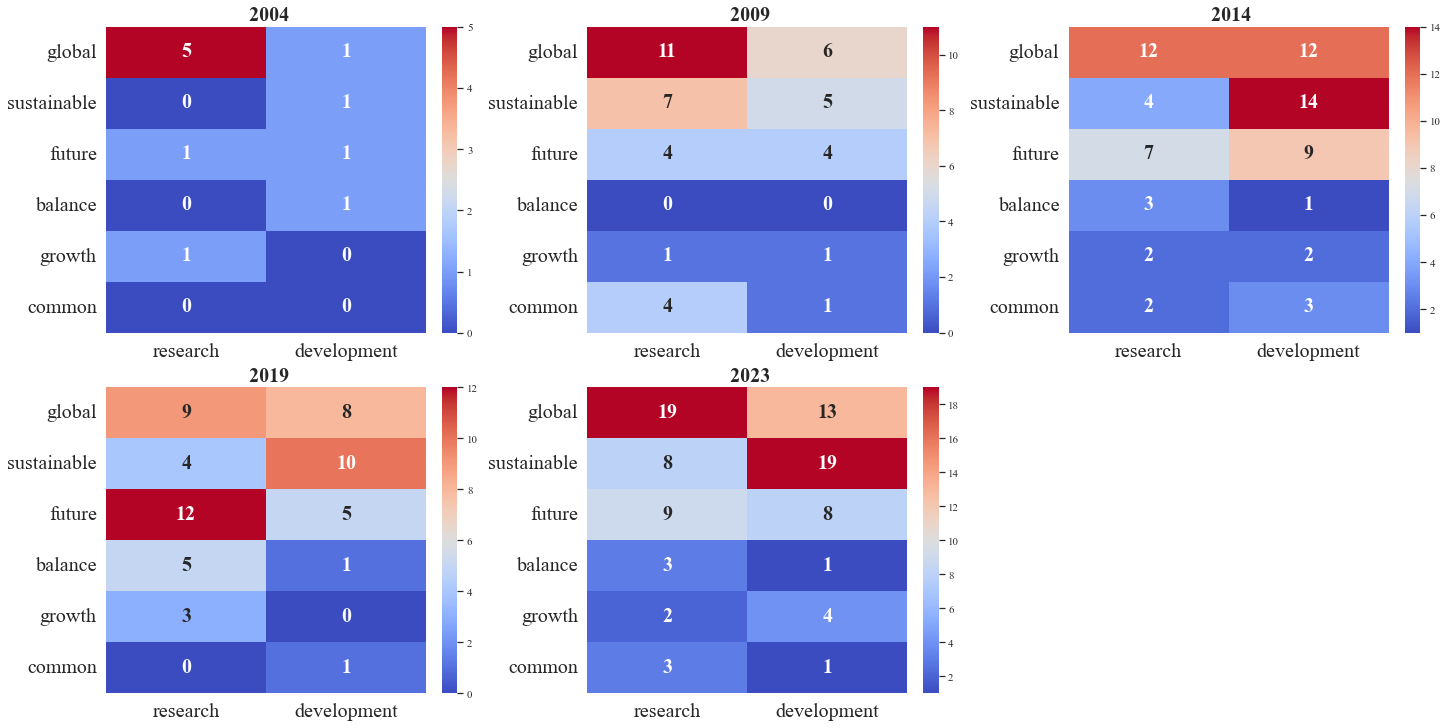

In [28]:
milestone_years = [2004, 2009, 2014, 2019, 2023]
basic_words = ['university', 'government', 'industry']
co_occurring_words = ['development', 'society', 'education', 'health', 
                      'policy', 'innovation', 'collaboration', 'research']
co_occurrence_dfs_by_year, sentence_counts_by_year = co_occurrence_analysis(df, milestone_years, basic_words, co_occurring_words)
plot_co_occurrence_heatmaps(co_occurrence_dfs_by_year, sentence_counts_by_year, 'stakeholders', normalized=False)

basic_words = ['science', 'technology']
co_occurring_words = ['progress', 'development', 'economics', 'society', 'humankind', 'education']
co_occurrence_dfs_by_year, sentence_counts_by_year = co_occurrence_analysis(df, milestone_years, basic_words, co_occurring_words)
plot_co_occurrence_heatmaps(co_occurrence_dfs_by_year, sentence_counts_by_year, 'sciecne_technology', normalized=False)

basic_words = ['research', 'development', ]
co_occurring_words = [ 'global','sustainable', 'future',  'balance', 'growth', 'common',]
co_occurrence_dfs_by_year, sentence_counts_by_year = co_occurrence_analysis(df, milestone_years, basic_words, co_occurring_words)
plot_co_occurrence_heatmaps(co_occurrence_dfs_by_year, sentence_counts_by_year, 'research_development',normalized=False)

# plot_co_occurrence_heatmaps(co_occurrence_dfs_by_year, sentence_counts_by_year, normalized=True)
# # plot_sentence_counts(sentence_counts_by_year)


In [26]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import itertools

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load data
df = pd.read_csv("summaries.csv")

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the replacements for specific phrases
phrase_replacements = {
    'internet of things': 'iot',
    'artificial intelligence': 'ai',
    'sustainable development goals': 'sdgs',
    'greenhouse gases': 'ghg',
    'information and communication technology': 'ict',
    'virtual reality': 'vr',
    'intellectual property': 'ip',
    'intellectual properties': 'ip',
    'augmented reality': 'ar',
    'cyber security': 'cybersecurity',
    'small modular reactors': 'smrs'
}

def replace_phrases(text):
    text = text.lower()  # Ensure text is lowercase
    for phrase, abbreviation in phrase_replacements.items():
        text = text.replace(phrase, abbreviation)
    return text

def clean_and_tokenize(text):
    text = replace_phrases(text)
    text = text.replace('\n', ' ')

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove punctuation and stopwords, and lemmatize
    stop_words = set(stopwords.words('english'))
    tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.isalpha() and word.lower() not in stop_words]

    return tokens

# Apply the cleaning and tokenization function to the 'Text' column
df['Tokenized Text'] = df['Text'].apply(clean_and_tokenize)

# Get the top 1000 words in the entire dataset
all_tokens = [token for sublist in df['Tokenized Text'] for token in sublist]
top_1000_words = [word for word, freq in Counter(all_tokens).most_common(1000)]

# Define the co-occurrence analysis function for top 1000 words across the entire dataset
def co_occurrence_analysis(df, top_words):
    df['Sentences'] = df['Text'].apply(sent_tokenize)

    # Initialize a counter to store co-occurrence counts
    co_occurrence_counts = Counter()

    # Function to count co-occurrences in sentences
    def count_co_occurrences(sentences):
        for sentence in sentences:
            words = clean_and_tokenize(sentence)
            filtered_words = [word for word in words if word in top_words]
            for word_pair in itertools.combinations(set(filtered_words), 2):
                sorted_pair = tuple(sorted(word_pair))
                co_occurrence_counts[sorted_pair] += 1

    # Apply co-occurrence counting to each row
    df['Sentences'].apply(count_co_occurrences)

    return co_occurrence_counts

# Perform co-occurrence analysis
co_occurrence_counts = co_occurrence_analysis(df, top_1000_words)

# Select the top 1000 co-occurrences
top_1000_co_occurrences = co_occurrence_counts.most_common(1000)

# Generate the nodes CSV
all_words = set(word for pair, count in top_1000_co_occurrences for word in pair)
nodes_df = pd.DataFrame(list(all_words), columns=['Id'])
nodes_df.to_csv('nodes.csv', index=False)

# Generate the edges CSV
edges = [[word1, word2, count] for (word1, word2), count in top_1000_co_occurrences]
edges_df = pd.DataFrame(edges, columns=['Source', 'Target', 'Weight'])
edges_df.to_csv('edges.csv', index=False)

print("Nodes and edges CSV files have been created successfully.")


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/norika_machome/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/norika_machome/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/norika_machome/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Nodes and edges CSV files have been created successfully.


## Frequency Count for token and bigram

In [30]:
# set up
beginning_years = normalized_word_freq_df.columns[:3]
ending_years = normalized_word_freq_df.columns[-3:]
initial_frequencies = normalized_word_freq_df[beginning_years].mean(axis=1)
final_frequencies = normalized_word_freq_df[ending_years].mean(axis=1)
initial_frequencies = initial_frequencies.replace(0, np.nan)
final_frequencies = final_frequencies.replace(0, np.nan)

#emerging word
growth_rates_3_years = (final_frequencies - initial_frequencies) / initial_frequencies
emerging_words_normalized_3_years = growth_rates_3_years[(final_frequencies > 0.001) & (growth_rates_3_years > 1)].sort_values(ascending=False)
top_100_emerging_words_normalized_3_years = emerging_words_normalized_3_years.head(100)
# print("Emerging Words over 3 years (Normalized):")
# print(top_100_emerging_words_normalized_3_years)
top_100_emerging_words_normalized_3_years.to_csv('top_100_emerging_words_normalized_3_years.csv', header=True)

#disapeering word
decrease_rates = (initial_frequencies - final_frequencies) / initial_frequencies
disappearing_words = decrease_rates[(initial_frequencies > 0.001) & (decrease_rates > 0.8)].sort_values(ascending=False)
top_100_disappearing_words = disappearing_words.head(100)
# print("Disappearing Words (Normalized):")
# print(top_100_disappearing_words)
top_100_disappearing_words.to_csv('top_100_disappearing_words_normalized_3_years.csv', header=True)

#sudden_peak
def find_sudden_peaks(df, threshold=3):
    peaks = {}
    for word in df.index:
        for year in df.columns[1:-1]:
            prev_year = year - 1
            next_year = year + 1
            if df.at[word, year] > threshold * df.at[word, prev_year] and df.at[word, year] > threshold * df.at[word, next_year]:
                if word not in peaks:
                    peaks[word] = []
                peaks[word].append(year)
    return peaks

sudden_peaks = find_sudden_peaks(normalized_word_freq_df)
# print("Sudden Peaks (Normalized):")
# for word, years in sudden_peaks.items():
#     print(f"{word}: {years}")
peaks_df = pd.DataFrame([(word, year) for word, years in sudden_peaks.items() for year in years], columns=['Word', 'Year'])
peaks_df.to_csv('sudden_peaks_normalized.csv', index=False)



## LDA Analysis

In [31]:

# Load data
df_statement = pd.read_csv("summaries_statement.csv")

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the replacements for specific phrases
phrase_replacements = {
    'internet of things': 'iot',
    'artificial intelligence': 'ai',
    'sustainable development goals': 'sdgs',
    'greenhouse gases': 'ghg',
    'information and communication technology': 'ict',
    'virtual reality': 'vr',
    'augmented reality': 'ar',
    'cyber security': 'cybersecurity'
}

def replace_phrases(text):
    text = text.lower()  # Ensure text is lowercase
    for phrase, abbreviation in phrase_replacements.items():
        text = text.replace(phrase, abbreviation)
    return text

def clean_and_tokenize(text):
    text = replace_phrases(text)
    text = text.replace('\n', ' ')

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove punctuation and stopwords, and lemmatize
    stop_words = set(stopwords.words('english')).union(set([
        'opening',  'proposed', 'open', 'tuesday', 'annual',
         'decided',  'minister', 'prime',  'shinzo', 'abe', 'mere', 'forum_held', 'er', 'th_annual'
        'september', 'october', 'meeting',  'year', 'wh', 'tokyo', 'multi', 'st', 'annual_sts', 'president'
         'tel', 'fax', 'http', 'conference', 'among_industry', 'kyoto', 'especially', 'took_place'
    ]))
    tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.isalpha() and word.lower() not in stop_words]

    # Join the tokens back into a string for Cleaned Text
    cleaned_text = ' '.join(tokens)
    return cleaned_text, tokens

# Apply the cleaning and tokenization function to the 'Text' column
df_statement['Cleaned Text'], df_statement['Tokenized Text'] = zip(*df_statement['Text'].apply(clean_and_tokenize))

# Train a bigram model
phrases = Phrases(df_statement['Tokenized Text'], min_count=5, threshold=10)
bigram = Phraser(phrases)
df_statement['Bigram Text'] = df_statement['Tokenized Text'].apply(lambda x: bigram[x])

# Join the bigram text for each statement
df_statement['Bigram Text Joined'] = df_statement['Bigram Text'].apply(lambda x: ' '.join(x))

# Create a document-term matrix using CountVectorizer
vectorizer = CountVectorizer(max_df=0.85, min_df=3, stop_words='english')
dtm = vectorizer.fit_transform(df_statement['Bigram Text Joined'])

# Apply LDA with 10 topics and hyperparameter tuning
lda = LatentDirichletAllocation(n_components=10, max_iter=50, learning_decay=0.8, random_state=42)
lda.fit(dtm)

# Display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

# Visualize the topics
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, dtm, vectorizer, mds='tsne')
pyLDAvis.display(panel)


Topic 0:
ai pandemic challenge information economic emission scientific world climate_change social
Topic 1:
social public international education humanity collaboration policy promote problem security
Topic 2:
living responsible rate rapid_progress deve bring response strain appropriate target
Topic 3:
pandemic challenge economic way vaccine common advanced social covid digital
Topic 4:
living responsible rate rapid_progress deve bring response strain appropriate target
Topic 5:
increasing collaboration researcher action nature food_water necessary supply concern recognize
Topic 6:
humankind agreed important scientist view international power importance recognized nuclear
Topic 7:
medium important climate_change promote nuclear service developing_country world support power
Topic 8:
forum developed sustainable_development woman leader better humanity create education resource
Topic 9:
life cooperation needed climate_change challenge leader effort world academia food


/Users/norika_machome/Library/Python/3.8/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/norika_machome/Library/Python/3.8/lib/python/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


/Users/norika_machome/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


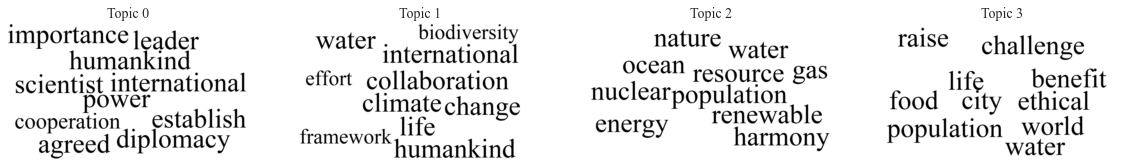

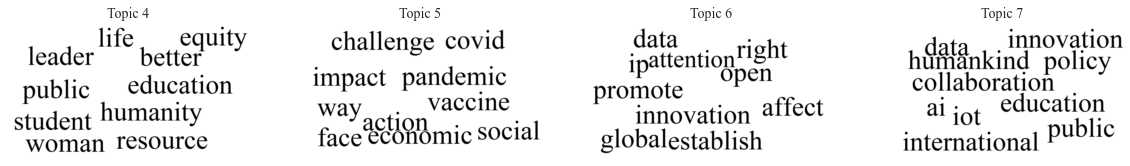

In [ ]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt

# # Define the topics dictionary
# topics = {
#     0: "humankind agreed power leader scientist establish international importance diplomacy cooperation",
#     1: "climate change life collaboration international humankind water biodiversity effort framework",
#     2: "energy resource nuclear renewable ocean water harmony gas nature population",
#     3: "world life population food challenge ethical raise benefit city water",
#     4: "public education leader humanity resource life better student woman equity",
#     5: "pandemic challenge economic way vaccine covid action impact face social",
#     6: "innovation affect ip global promote right establish data open attention",
#     7: "ai humankind innovation iot public collaboration education international data policy"
# }

# # Function to make all words black
# def black_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
#     return "rgb(0, 0, 0)"

# # Function to assign size based on the order of words
# def generate_weighted_text(text):
#     words = text.split()
#     weighted_text = " ".join([word + " " * (len(words) - i) for i, word in enumerate(words)])
#     return weighted_text

# # Customize the appearance of the word clouds
# wordcloud_config = {
#     'width': 900,
#     'height': 500,
#     'background_color': 'white',
#     'max_words': 10,
#     'contour_color': 'steelblue',
#     'contour_width': 2,
#     'scale': 2,  # Scale up the entire word cloud
#     'max_font_size': 100,  # Increase the maximum font size
#     'relative_scaling': 1,  # Increase the difference in size between words
#     'prefer_horizontal': 1.0,  # Make all words horizontal
#     'color_func': black_color_func,  # Make all words black
#     'font_path': '/System/Library/Fonts/Supplemental/Times New Roman.ttf'  # Specify the path to your font file
# }

# # Set the global font family to Times New Roman
# plt.rcParams["font.family"] = "Times New Roman"

# Generate word clouds and store them in a list
wordclouds = []
for topic, keywords in topics.items():
    weighted_text = generate_weighted_text(keywords)
    wordcloud = WordCloud(**wordcloud_config).generate(weighted_text)
    wordclouds.append(wordcloud)

# Create a figure to display the word clouds in a 2x4 grid with custom spacing
fig1, axes1 = plt.subplots(1, 4, figsize=(20, 5))
fig2, axes2 = plt.subplots(1, 4, figsize=(20, 5))

# Adjust space between all plots
fig1.subplots_adjust(wspace=0.2, hspace=0.1)
fig2.subplots_adjust(wspace=0.2, hspace=0.1)

# Plot the first four word clouds
for i in range(4):
    axes1[i].imshow(wordclouds[i], interpolation='bilinear')
    axes1[i].axis('off')
    axes1[i].set_title(f'Topic {i}', fontsize=14)

# Plot the last four word clouds
for i in range(4, 8):
    axes2[i-4].imshow(wordclouds[i], interpolation='bilinear')
    axes2[i-4].axis('off')
    axes2[i-4].set_title(f'Topic {i}', fontsize=14)

# Save the figures
fig1.savefig('wordcloud_topics_0_to_3_sub.png', bbox_inches='tight')
fig2.savefig('wordcloud_topics_4_to_7_sub.png', bbox_inches='tight')

# Display the figures
plt.show()


In [ ]:



# topics_emerging = ['sdgs', 'pandemic', 'big_data', 'smart_city', 'cybersecurity']
# topics_emerging_test = ['open_science', 'space', 'ocean'] 
# topic_ethics = ['privacy', 'trust', 'media', 'big_data']

# topics_constant = ['energy', 'food', 'population', 'ip', 'education' ]
# topics_non_emerging = ['nanotechnology', 'biodiversity', 'disaster', 'water', 'manifacturing' ]
# topics_ai = ['ai', 'iot', 'ict', 'cybersecurity', 'robotics', 'big_data']
# topics_climate_change = ['climate_change', 'biodiversity', 'water', 'framework', 'sustainability', 'green_technology']
# topics_energy = ['energy', 'fossil_fuel', 'natural_gas', 'resource', 'nuclear', 'renewable', 'ocean', 'harmony', 'gas', 'nature', 'population', 'smrs']
# topics_urban_development = [ 'education', 'city', 'food', 'population']
# topics_education = ['education', 'women', 'public', 'leader', 'student', 'equity']
# topics_pandemic = ['pandemic', 'economic', 'vaccine', 'covid', 'action', 'impact', 'face', 'social', 'crisis']
# topics_innovation = ['innovation', 'ip', 'global', 'promote', 'data', 'open', 'intellectual_property']
# topics_global_cooperation = ['humankind', 'agreed', 'power', 'scientist', 'diplomacy', 'establish', 'international', 'importance', 'cooperation', 'leader']

# # Plot trends for each topic category
# plot_word_trends(['ai', 'iot', 'cybersecurity', 'big_data'], 'Trends in Emerging Topics (Technology)', year_range_flag=20)
# plot_word_trends(['sdgs', 'smart_city', 'renewable_energy' ], 'Trends in Emerging Topics (Sustainability)', 20)
# plot_word_trends(['pandemic', 'vaccine', 'mrna', 'covid'] , 'Trend in Emerging Topics (Pandemic)', 20)
# plot_word_trends(['food', 'water', 'population', 'education', 'energy'] , 'Trend in Topics (Food)', 20)
# plot_word_trends([ 'coal', 'oil', 'natural_gas', 'nuclear_energy', 'fossil_fuel', 'carbon', 
#     'emissions', 'carbon_footprint', 'pollution'], 'Trend in Energy', 20)
    
# #     'climate_change', 'sustainability', 
# #     'led_lighting', 'energy_saving_appliances', 'insulation', 'high_efficiency_heating_cooling', 
# #     'energy_management_systems', 'regulatory_bodies', 'compliance_standards', 
# #     'safety_standards', 'environmental_impact_assessments', 'legal_aspects_of_energy_production'
# # ]

# # plot_word_trends(['space', 'satellite'] , 'Trend in Topics (Space)', 20)
# # plot_word_trends(['science_diplomacy', 'cooperation', 'collaboration', 'diplomacy', 'partnership'], 'Trends in Global Cooperation Related Topics', 20)
# # plot_word_trends(topics_emerging_test, 'Trends in Test Topics', 20)
# # plot_word_trends(topic_ethics, 'Trends in Ethics Topics', 20)

# # plot_word_trends(topics_constant, 'Trends in Constant Topics', 20)

# # plot_word_trends(topics_non_emerging, 'Trends in Non Emerging Topics', 20)
# # plot_word_trends(topics_ai, 'Trends in AI Related Topics', 20)
# # plot_word_trends(topics_climate_change, 'Trends in Climate Change Related Topics', 20)
# # plot_word_trends(topics_energy, 'Trends in Energy Related Topics', 20)
# # plot_word_trends(topics_urban_development, 'Trends in Urban Development Related Topics', 20)
# # plot_word_trends(topics_education, 'Trends in Education Related Topics', 20)
# # plot_word_trends(topics_pandemic, 'Trends in Pandemic Related Topics', 20)
# # plot_word_trends(topics_innovation, 'Trends in Innovation Related Topics', 20)


# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# def plot_cumulative_word_groups_trends(word_groups, labels, title, df, normalized=False):
#     sns.set(style="whitegrid")
#     plt.figure(figsize=(12, 8))

#     if len(word_groups) != len(labels):
#         raise ValueError("The number of labels must match the number of word groups.")

#     # Set the year range based on the dataframe columns
#     years = df.columns

#     for words, label in zip(word_groups, labels):
#         cumulative_freq = pd.DataFrame(index=years)
#         for word in words:
#             if word in df.index:
#                 cumulative_freq[word] = df.loc[word]
#         cumulative_freq['Cumulative'] = cumulative_freq.sum(axis=1)

#         if normalized:
#             # Normalize the cumulative frequency by the total word count for each year
#             total_words_per_year = df.sum(axis=0)
#             normalized_cumulative_freq = cumulative_freq['Cumulative'] / total_words_per_year
#             sns.lineplot(data=normalized_cumulative_freq, label=label, marker='o')
#         else:
#             sns.lineplot(data=cumulative_freq['Cumulative'], label=label, marker='o')

#     plt.axvline(x=2013.5, color='gray', linestyle='--', linewidth=1)
#     plt.xlabel('Year', fontsize=16)
#     plt.ylabel('Normalized Cumulative Frequency' if normalized else 'Cumulative Frequency', fontsize=16)
#     plt.title(title, fontsize=18, fontweight='bold')
#     plt.legend(title='Word Groups', fontsize=14, title_fontsize='16')
#     plt.xticks(ticks=[int(year) for year in years], fontsize=12)
#     plt.yticks(fontsize=12)
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# # Example word groups and labels
# words = [
#     ['energy', 'coal', 'oil', 'natural_gas', 'nuclear_energy', 'fossil_fuel', 'renewable_energy'],
#     ['climate_change', 'emissions', 'greenhouse_gases', 'carbon', 'carbon_dioxide', 'global_warming'],
#     ['earth', 'biodiversity', 'water', 'ocean', 'forest', 'land', 'sustainability']
# ]
# labels = ['Energy', 'Climate Change', 'Earth and Commons']

# # Example usage with the DataFrame, not the dictionary
# plot_cumulative_word_groups_trends(words, labels, 'Cumulative Trends in Selected Topics (Absolute)', word_freq_df, normalized=False)
# plot_cumulative_word_groups_trends(words, labels, 'Cumulative Trends in Selected Topics (Normalized)', normalized_word_freq_df, normalized=True)
